# Chest X-Ray Pneumonia detection with convolutional neural network

## 1. Setup

In [4]:
import warnings
warnings.filterwarnings('ignore')

import re
import os
import cv2

import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline
import random
import os
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import glob

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


Initialize all random units to the same seed.

In [6]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.utils.set_random_seed(SEED)
# this may not work with old tensorflow versions

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

These are the global variables used during the code:
  - AUTOTUNE For monitoring and optimization. It is used when preparing the data for training.
  -  BATCH_SIZE The number of images taken for each group while training.
  -  IMAGE_SIZE This variable is the size of the scans after preprocessing.
  -  EPOCHS The iterations of the training.
  -  IMAGE_CROP The percentage of image we want to keep, when applying central cropping [0,1].
  -  RANDOM_STATE We added the Random State to compare the results not depending on the seed.

In [7]:
data_dir = "scaled_chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_CROP = 1
RANDOM_STATE = 0

## 2. Load the data

The Chest X-ray data we are using from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images divides the data into train and test files. We will append the test files and create a new split.
- 20% test files
- 64% training files
- 16% validation files

In [8]:
filenames = tf.io.gfile.glob(str(train_dir + '/*/*'))
filenames.extend(tf.io.gfile.glob(str(test_dir + '/*/*')))

# Split arrays or matrices into random train and test subsets.
t_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state = RANDOM_STATE)
dev_filenames, val_filenames = train_test_split(t_filenames, test_size=0.2, random_state = RANDOM_STATE)

In [9]:
COUNT_NORMAL_dev = len([filename for filename in dev_filenames if "NORMAL" in filename])
print("Normal images count in dev set: " + str(COUNT_NORMAL_dev))

COUNT_PNEUMONIA_dev = len([filename for filename in dev_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in dev set: " + str(COUNT_PNEUMONIA_dev))
print("Sum: " + str(len(dev_filenames)))
print('---------------------------')

#########################################################################################

COUNT_NORMAL_val = len([filename for filename in val_filenames if "NORMAL" in filename])
print("Normal images count in validation set: " + str(COUNT_NORMAL_val))

COUNT_PNEUMONIA_val = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in validation set: " + str(COUNT_PNEUMONIA_val))
print("Sum: " + str(len(val_filenames)))
print('---------------------------')

#########################################################################################

COUNT_NORMAL_test = len([filename for filename in test_filenames if "NORMAL" in filename])
print("Normal images count in test set: " + str(COUNT_NORMAL_test))

COUNT_PNEUMONIA_test = len([filename for filename in test_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA_test))
print("Sum: " + str(len(test_filenames)) + '\n\n')

Normal images count in dev set: 999
Pneumonia images count in dev set: 2748
Sum: 3747
---------------------------
Normal images count in validation set: 273
Pneumonia images count in validation set: 664
Sum: 937
---------------------------
Normal images count in test set: 311
Pneumonia images count in test set: 861
Sum: 1172




Note that there are way more images classified as PNEUMONIA than NORMAL in the training, validation and test sets.

In [10]:
def plot_dataset(n,p,name):
    X_axis = np.arange(len(name))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    
    plt.bar(X_axis - 0.2, n, 0.4, label = 'Normal(0)')
    plt.bar(X_axis + 0.2, p, 0.4, label = 'Pneumonia(1)')

    plt.xticks(X_axis, name)
    plt.xlabel('Sets', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Number of cases in sets', fontsize=14)
    plt.legend()
    
    plt.show()

The following plot visualizes the imbalance of the datasets.

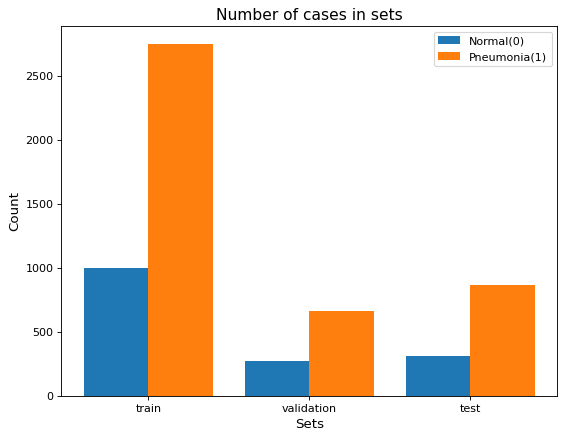

In [11]:
# Plot the results 
plot_dataset([COUNT_NORMAL_dev, COUNT_NORMAL_val, COUNT_NORMAL_test], [COUNT_PNEUMONIA_dev, COUNT_PNEUMONIA_val, COUNT_PNEUMONIA_test], ['train', 'validation', 'test'])

Until now, we only have 3 arrays of filenames.
We will now create datasets from the arrays.

In [12]:
dev_list_ds = tf.data.Dataset.from_tensor_slices(dev_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

print('Some example filenames: \n')
for f in dev_list_ds.take(5):
    print(f.numpy())

Some example filenames: 

b'scaled_chest_xray\\train\\PNEUMONIA\\VIRUS-3523856-0003.jpeg'
b'scaled_chest_xray\\train\\PNEUMONIA\\BACTERIA-198200-0002.jpeg'
b'scaled_chest_xray\\train\\PNEUMONIA\\VIRUS-667894-0001.jpeg'
b'scaled_chest_xray\\train\\NORMAL\\NORMAL-7920733-0001.jpeg'
b'scaled_chest_xray\\train\\PNEUMONIA\\VIRUS-1546263-0005.jpeg'


The number of elements in the datasets should be the same as before.

In [13]:
DEV_IMG_COUNT = tf.data.experimental.cardinality(dev_list_ds).numpy()
print("Training images count: " + str(DEV_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Testing images count: " + str(TEST_IMG_COUNT))

Training images count: 3747
Validating images count: 937
Testing images count: 1172


We already know that there are only two class names.

In [14]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
CLASS_NAMES

['NORMAL', 'PNEUMONIA']

Currently our dataset is just a list of filenames. For our NN we want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.
As we only have two labels, we will rewrite the label so that 1 or True indicates pneumonia and 0 or False indicates normal.

In [15]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [16]:
'''
Function that applies Gaussian Noise to the images.
'''
def add_gaussian_noise(img):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=(200)/(255), dtype=tf.float32)
        noise_img = img + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img

In [17]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # For keeping only a portion of the image
    img = tf.image.central_crop(img, IMAGE_CROP)
    # For adding some noise
    #img = add_gaussian_noise(img)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)

The following method gets the image and the label from the path.

In [18]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [19]:
train_ds = dev_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (180, 180, 3)
Label:  True


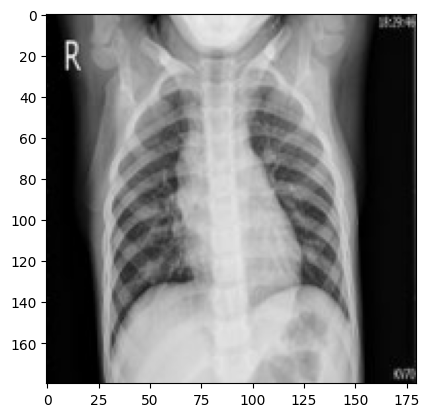

In [20]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image)

## 3. Visualize the dataset

Let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [21]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
      if isinstance(cache, str):
          ds = ds.cache(cache)
      else:
          ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [22]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = test_ds.batch(BATCH_SIZE)

image_batch, label_batch = next(iter(train_ds))

In [23]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

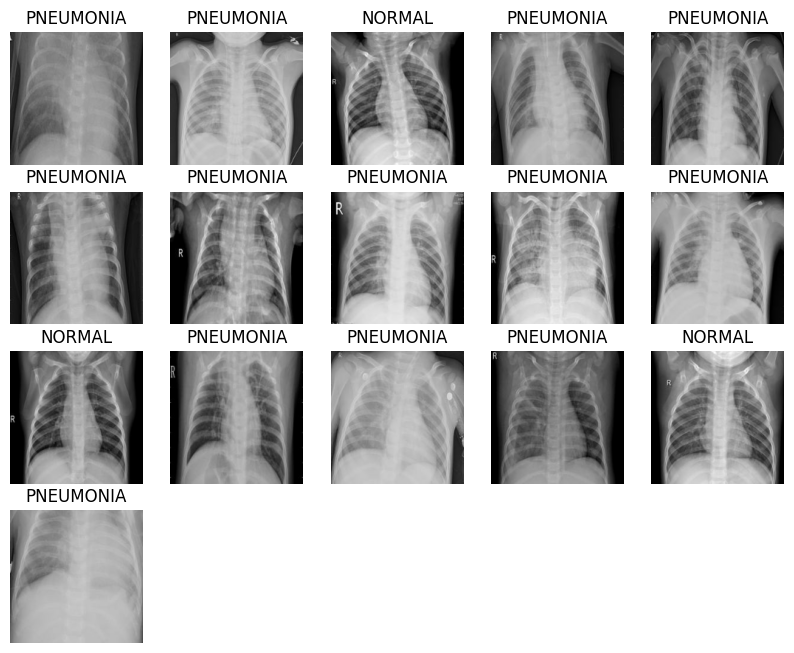

In [24]:
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. Build the Models

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

Convolutional block is composed of of two separable convolution layers, max-pooling and batch-normalization.

In [25]:
def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ]
  )

  return block

The dense block is built using a dense layer, a batch normalization and a dropout.

In [26]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])
  
  return block

### CNN Model

The model is built using an input layer, two convolutional layers and a MaxPooling one. The following structure is composed of convolutional blocks, dropout layers (to reduce overfitting), a flatten layer, three dense blocks and finally a dense layer.

The following method will define the function to build our model for us. The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer of one node, as this will be the output that determines if an X-ray shows an image of pneumonia.

In [27]:
def build_CNN_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


### NN Model

In [28]:
def build_NN_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. Solve the problem of data imbalance
### Calculate class weights
The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [29]:
weight_for_0 = (1 / COUNT_NORMAL_dev) * (DEV_IMG_COUNT / 2.0)
weight_for_1 = (1 / COUNT_PNEUMONIA_dev) * (DEV_IMG_COUNT / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 1.88
Weight for class 1: 0.68


## 6. Train the model

Since there are only two possible labels for the image, we will be using the binary_crossentropy loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

In the following part of the code we build our model, define the metrics that should be used to evaluate it, we define the optimizer and the loss function. The activation function are ReLU throughout except for the last layer where it is Sigmoid, as this is a binary classification problem.


In [30]:
CNN_model = build_CNN_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

CNN_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)
CNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 45, 45, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       27072     
                                                      

In [31]:
NN_model = build_NN_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

NN_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 97200)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               49766912  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [32]:
CNN_history = CNN_model.fit(
    train_ds,
    steps_per_epoch=DEV_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weights,
)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
NN_history = NN_model.fit(
    train_ds,
    steps_per_epoch=DEV_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weights,
)

## Training Results Plotting

In [ ]:
print("CNN")
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(CNN_history.history[met])
    ax[i].plot(CNN_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
print("\nNN")
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(NN_history.history[met])
    ax[i].plot(NN_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Test Results

In [35]:
print("CNN")
loss, acc, prec, rec = CNN_model.evaluate(test_ds)
print("\nNN")
loss, acc, prec, rec = NN_model.evaluate(test_ds)

CNN
37/37 [==============================] - 5s 118ms/step - loss: 0.6931 - accuracy: 0.2654 - precision: 0.0000e+00 - recall: 0.0000e+00

NN
37/37 [==============================] - 3s 42ms/step - loss: 0.7063 - accuracy: 0.3951 - precision: 0.6238 - recall: 0.4448


## 7. Finetuning the models

In order to finetune our model, we'll need some training callbacks.

### Model Checkpoint

In [36]:
CNN_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xRay_CNN_Net.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
NN_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xRay_NN_Net.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

### Early Stopping

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

In [37]:
earlyStopping_cb = tf.keras.callbacks.EarlyStopping(
  patience=10,
  restore_best_weights=True,
)

### Learning rate exponential decay

In [38]:
initial_learning_rate = 0.1

def lr_scheduler(epoch):
  k = 0.1
  lrate = initial_learning_rate * np.exp(-k*epoch)
  return lrate

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

We can now retrain our model and use the defined callbacks to further increase the performance of the model.

In [ ]:
CNN_history = CNN_model.fit(
    train_ds,
    steps_per_epoch=DEV_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[CNN_checkpoint_cb, earlyStopping_cb, lr_schedule_cb],
) 

In [ ]:
NN_history = NN_model.fit(
    train_ds,
    steps_per_epoch=DEV_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[NN_checkpoint_cb, earlyStopping_cb, lr_schedule_cb],
) 

In [ ]:
print("CNN")
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(CNN_history.history[met])
    ax[i].plot(CNN_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
print("\nNN")
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(CNN_history.history[met])
    ax[i].plot(CNN_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 8. Model performance and evaluation of results

### Get the predictions. 

In [40]:
preds_CNN = (CNN_model.predict(test_ds, batch_size=16) > 0.5).astype("int32")
preds_NN = (NN_model.predict(test_ds, batch_size=16) > 0.5).astype("int32")

37/37 [==============================] - 2s 38ms/step


### Get the original labels of the images.

In [41]:
#Get the original labels of each image
orig_test_labels = []
for image, label in test_ds.as_numpy_iterator():
    for x in label:
        orig_test_labels.append(x)
print(np.array(orig_test_labels).shape)
print(np.array(preds_CNN).shape)
print(np.array(preds_NN).shape)

(1172,)
(1172, 1)
(1172, 1)


In [42]:
print(np.array(orig_test_labels))
print(np.array(preds_CNN).flatten())
print(np.array(preds_NN).flatten())

[ True  True False ...  True  True  True]
[0 0 0 ... 0 0 0]
[1 0 1 ... 0 1 1]


The **confusion matrix** is convinient to understand how the predictions went.

![](assets/confusionMatrix.png)

### Performance of CNN

<Figure size 640x480 with 0 Axes>

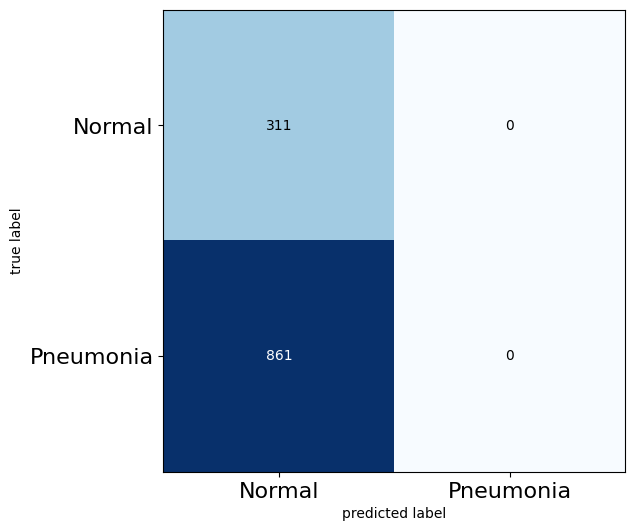

In [47]:
# Get the confusion matrix
cm_CNN  = confusion_matrix(orig_test_labels, preds_CNN)
plt.figure()
plot_confusion_matrix(cm_CNN,figsize=(10,6), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [48]:
loss_CNN, acc_CNN, prec_CNN, rec_CNN = CNN_model.evaluate(test_ds)

37/37 [==============================] - 4s 104ms/step - loss: 0.6931 - accuracy: 0.2654 - precision: 0.0000e+00 - recall: 0.0000e+00


In [50]:
print('Evaluate function calculating...')
print("Recall of the model is {:.3f}".format(rec_CNN))
print("Precision of the model is {:.3f}".format(prec_CNN))

# Checking if the results are correct by manually calculating Precision and Recall with confusion matrix results
print('\nManually calculating...')
tn, fp, fn, tp = cm_CNN.ravel()

precision_CNN = tp/(tp+fp)
recall_CNN = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall_CNN))
print("Precision of the model is {:.3f}".format(precision_CNN))

Evaluate function calculating...
Recall of the model is 0.000
Precision of the model is 0.000

Manually calculating...
Recall of the model is 0.000
Precision of the model is nan


### Performance of NN

<Figure size 640x480 with 0 Axes>

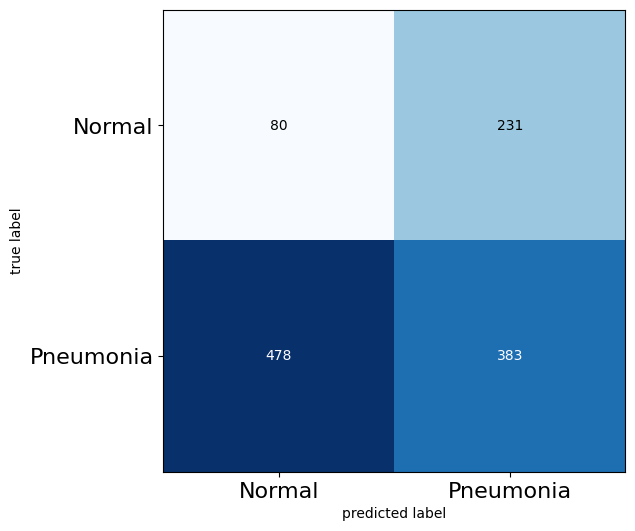

In [51]:
cm_NN  = confusion_matrix(orig_test_labels, preds_NN)
plt.figure()
plot_confusion_matrix(cm_NN,figsize=(10,6), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [54]:
loss_NN, acc_NN, prec_NN, rec_NN = NN_model.evaluate(test_ds)

37/37 [==============================] - 2s 41ms/step - loss: 0.7063 - accuracy: 0.3951 - precision: 0.6238 - recall: 0.4448


In [56]:
print('Evaluate function calculating...')
print("Recall of the model is {:.3f}".format(rec_NN))
print("Precision of the model is {:.3f}".format(prec_NN))

# Checking if the results are correct by manually calculating Precision and Recall with confusion matrix results
print('\nManually calculating...')
tn, fp, fn, tp = cm_NN.ravel()

precision_NN = tp/(tp+fp)
recall_NN = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall_NN))
print("Precision of the model is {:.3f}".format(precision_NN))

Evaluate function calculating...
Recall of the model is 0.445
Precision of the model is 0.624

Manually calculating...
Recall of the model is 0.445
Precision of the model is 0.624
